# 目标检测数据集

我们收集并标记了一个小型数据集
下载数据集

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

读取香蕉检测数据集

In [2]:
def read_data_bananas(is_train=True): # 控制读取训练集还是验证集
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    # 根据 is_train 选择 bananas_train 或 bananas_val 子目录，CSV文件：存储每张图片对应的边界框坐标
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    # 将 img_name 列设为行索引，便于后续按文件名快速查找
    csv_data = csv_data.set_index('img_name')
    # images: 存储图像张量；targets: 存储边界框坐标
    images, targets = [], []
    # iterrows(): 逐行遍历，返回 (索引, 数据) 对
    for img_name, target in csv_data.iterrows():
        '''
        构建完整图像路径：.../bananas_train/images/0.jpg
        torchvision.io.read_image: 读取图片并直接转为CHW格式张量（C=通道, H=高, W=宽）
        值范围: [0, 255]，类型为 torch.uint8
        '''
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        '''将target Series转为列表：[45, 60, 120, 180]，追加到targets列表'''
        targets.append(list(target))
    '''
    torch.tensor(targets):将所有框转换为张量，形状(num_images,4)
    .unsqueeze(1):增加维度→(num_images,1,4)
    原因：每个图像只有一个香蕉，增加维度方便后续批处理
    / 256: 归一化，将像素坐标 [0,256] 转为 [0,1]
    原因：模型训练和推理使用归一化坐标，更稳定
    '''
    return images, torch.tensor(targets).unsqueeze(1) / 256

创建一个自定义`Dataset`实例

In [3]:
'''
继承 torch.utils.data.Dataset：PyTorch 所有数据集类的基类
作用: 让数据可以与 DataLoader 无缝配合，实现批量加载、多线程等
'''
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))
    '''
    索引访问：通过dataset[i]获取第i个样本
    数据转换：将图像张量转为float类型（模型输入需要）
    返回值：元组 (图像,标签)
    '''
    def __getitem__(self, idx): # 获取样本
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self): # 获取长度
        return len(self.features)

为训练集和测试集返回两个数据加载器实例

In [4]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True) # 随机打乱
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

读取一个小批量，并打印其中的图像和标签的形状

In [5]:
# 1. 设置超参数
batch_size, edge_size = 32, 256 # 每个训练批次包含32张图片；每张图片被缩放为256×256像素（正方形）
# 2. 加载数据迭代器
'''
调用封装函数加载香蕉数据集
返回两个迭代器：训练集和验证集
_  ：忽略验证集（用下划线占位）
train_iter 是 torch.utils.data.DataLoader 对象，支持批量加载、打乱、多线程
'''
train_iter, _ = load_data_bananas(batch_size)
# 3. 获取一个批次
'''
iter(train_iter)：将 DataLoader 转为迭代器
next(...)：取出第一个批次的数据
batch 是一个元组：(images, labels)
'''
batch = next(iter(train_iter))
# 4. 查看数据形状
# batch[0]：图像张量；batch[1]：边界框标签
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

演示

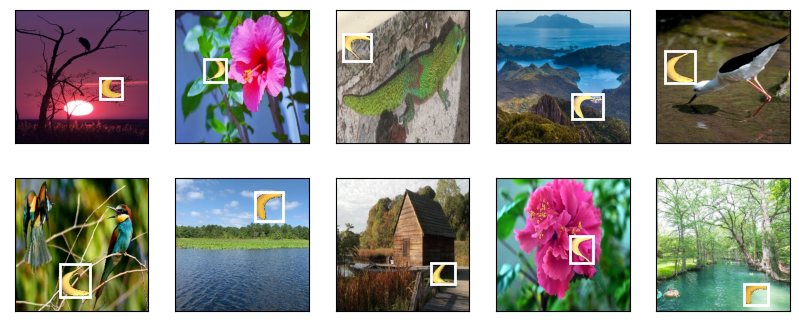

In [6]:
'''
1. 准备图像数据
batch[0]:图像张量，形状(batch_size,3,256,256) (N,C,H,W)格式
[0:10]:取前10张图片→形状(10,3,256,256)
.permute(0,2,3,1):重排维度→(10,256,256,3)
从CHW转为HWC格式（matplotlib需要）
/ 255:将像素值从[0,255]归一化到[0,1]，便于显示
'''
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
'''
2. 显示图像网格
imgs:准备好的图像数据 (10,256,256,3)
2,5:2行5列网格布局（共显示10张图）
scale=2:缩放因子，控制图像显示大小
返回值:axes是10个子图坐标轴对象的列表
'''
axes = d2l.show_images(imgs, 2, 5, scale=2)
'''
3. 遍历图像和标签
axes:10个子图的坐标轴对象
batch[1]:标签张量，形状(batch_size,1,4)；格式:[类别,x_min,y_min,x_max,y_max]（已归一化）
[0:10]:取前10个标签→形状 (10,1,4)
zip(ax,label):将每个子图与对应的标签配对
'''
for ax, label in zip(axes, batch[1][0:10]):
    '''
    4. 绘制边界框
    label[0]:取出第0个框（每张图只有1个香蕉）；形状: (5,) = [类别, x1, y1, x2, y2]
    label[0][1:5]:切片提取坐标部分（跳过类别）；结果: (4,) = [x1, y1, x2, y2]
    * edge_size:反归一化，将 [0,1] 的坐标乘以 256 → 像素坐标
    [...]:包裹成列表（show_bboxes 接受框列表）
    colors=['w']:设置边界框颜色为白色（'w'=white）
    '''
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])